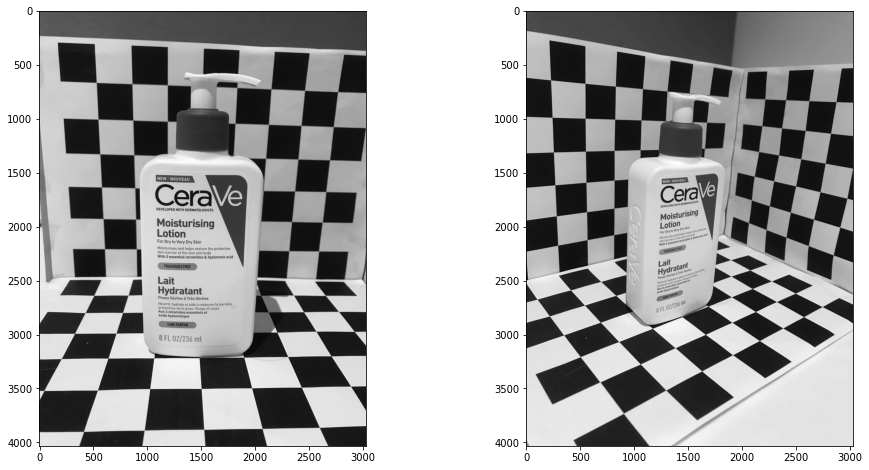

In [7]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

img_file1 = "./images3/1.jpg"
img_file2 = "./images3/2.jpg"
img1 = cv.imread(r'../images3/FD_object/1.jpg',cv.IMREAD_GRAYSCALE)           # queryImage
img2 = cv.imread(r'../images3/FD_object/2.jpg',cv.IMREAD_GRAYSCALE)           # trainImage

figure, ax = plt.subplots(1, 2, figsize=(16, 8))

ax[0].imshow(img1, cmap='gray')
ax[1].imshow(img2, cmap='gray')

In [8]:
# Initiate SIFT detector
sift = cv.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
print("The length of detected features in image 1 is ", np.size(kp1))
print("The length of detected features in image 2 is ", np.size(kp2))

# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)

flann = cv.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)
pts1 = []
pts2 = []
# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)

The length of detected features in image 1 is  9086
The length of detected features in image 2 is  10411


In [9]:
# find the Fundamental Matrix based on the list of matched points
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
F, mask = cv.findFundamentalMat(pts1,pts2,cv.FM_RANSAC)
print(F);

# We select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

[[-8.61170388e-06  2.21168972e-05 -7.23005351e-02]
 [-2.21304289e-07  9.71903841e-07  1.40177039e-01]
 [ 5.63154171e-02 -1.45971801e-01  1.00000000e+00]]


In [10]:
num_of_inliers = np.size(pts1, 0)
num_of_outliers1 = np.size(kp1) - num_of_inliers
num_of_outliers2 = np.size(kp2) - num_of_inliers
print("The number of inlier points = ", num_of_inliers)
print("The number of outlier points of image 1 = ", num_of_outliers1)
print("The number of outlier points of image 2 = ", num_of_outliers2)

The number of inlier points =  497
The number of outlier points of image 1 =  8589
The number of outlier points of image 2 =  9914


In [11]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv.cvtColor(img1,cv.COLOR_GRAY2BGR)
    img2 = cv.cvtColor(img2,cv.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv.circle(img1,tuple(pt1),25,color,-1)
        img2 = cv.circle(img2,tuple(pt2),25,color,-1)
    return img1,img2

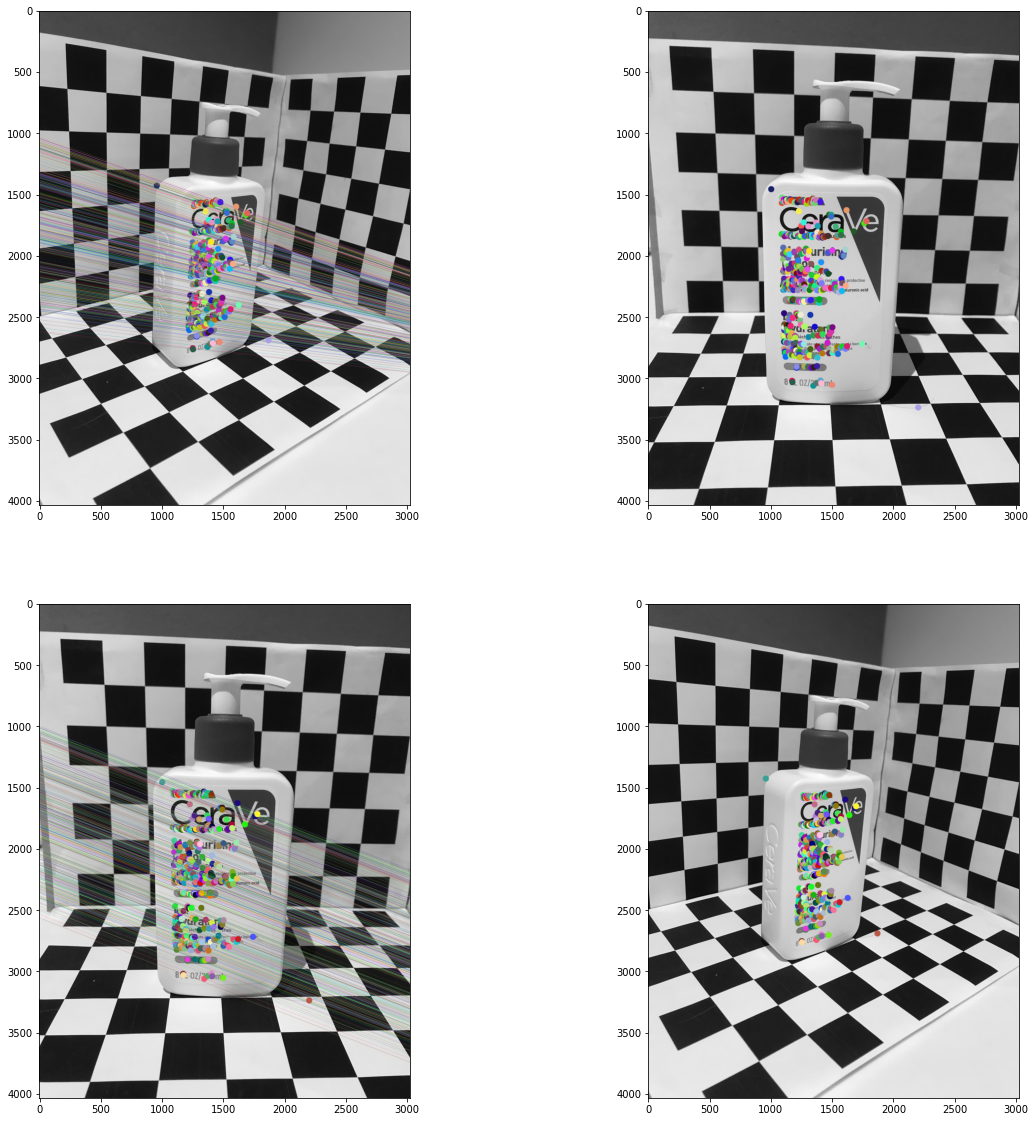

In [12]:
# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)
# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)
plt.figure(figsize=(20, 20))
plt.subplot(221),plt.imshow(img3)
plt.subplot(222),plt.imshow(img4)
plt.subplot(223),plt.imshow(img5)
plt.subplot(224),plt.imshow(img6)
plt.show()